In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import pickle

from scipy.sparse import csr_matrix

In [2]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arrX = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arrY = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arrX,arrY)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

## 1 局部聚类，得到子簇

In [3]:
# 确保定义的距离是有效的，非负性，同一性，对称性，直递性（三角不等式）

def dist(tr1,tr2):
    length = len(tr1)
    if not(length == 1000):
        # 传入参数形式为(k,1000)
        # 计算k个簇心点更新前后的距离
        distance = 0
        for i in range(length):
            pre = tr1[i]
            now = tr2[i]
            half = int(len(pre)/2)
            x1 = pre[0:half]
            y1 = pre[half:]
            x2 = now[0:half]
            y2 = now[half:]
            deta_x = x1 - x2
            deta_y = y1 - y2
            distance = distance + np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
    else:       
        half = int(length/2)
        x1 = tr1[0:half]
        y1 = tr1[half:]
        x2 = tr2[0:half]
        y2 = tr2[half:]
        deta_x = x1 - x2
        deta_y = y1 - y2
        distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
        # print(distance)
    return distance

In [4]:
def cluster(data,K):

    metric = distance_metric(type_metric.USER_DEFINED, func=dist)
    initial_centers = kmeans_plusplus_initializer(data, K).initialize()

    kmeans_instance = kmeans(data, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
    
    return clusters,centers

In [5]:
# ndarray中每个元素长度要相等
def getKmeansResult(data,K):
    clusters,centers = cluster(data,K)
    labels = np.zeros(NUM_TR)
    for i in range(K):
        for j in range(NUM_TR):
            if j in clusters[i]:
                labels[j] = i
    return labels,np.array(centers)

In [17]:
def stableKeanmsClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(50): # 取10次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print('min_cost:'+str(min_cost))
    return labels,centers

In [6]:
def cost(data,labels,centers):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(data[i],centers[int(labels[i])])
    loss = loss / len(data)
    return loss # 平均每个簇的损失

In [118]:
def chooseK(data,K):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels,centers = getKmeansResult(data,k)
        y[k-3] = cost(data, labels,centers)
    plt.plot(x,y)
    plt.xlabel('K')
    plt.ylabel('cost')
    plt.grid(True)
    plt.show()

#### 1.1 选择 K 值

#### 1.2 choose K,聚类

### 为什么形成的子簇中的轨迹需要尽可能拥有相同的走势？
- 假设形成的某一个子簇中的轨迹有着大程度上的不同走势：轨迹A和轨迹B若存在点交叉的部分（这是大概率会发生的事情），而此时假设轨迹A和轨迹B的走势完全不同，则在交叉点之前可能是A走势，交叉点后有可能会按照B走势进行，这样生成的轨迹是不包含在这个子簇分布里面的。
- 如果子簇中的大部分轨迹走势类似，则在交叉点前后是同一走势，不会生成不符合子簇分布的轨迹。

## 2 网格化矩阵

In [7]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

## 3 生成模型

In [9]:
def checkDiscTr(data):
    for index in range(len(data)):
        tr = data[index]
        for i in range(len(tr)-1):
            nowP = tr[i]
            nextP = tr[i+1]
            if np.abs(nextP[0]-nowP[0])+np.abs(nextP[1]-nowP[1]) > 1:
                print('wroooooooooooooong!!!')
                print(nowP,nextP,index)

In [ ]:
def markovModle(disc_tr,all_point):
    print('checkDISC')
    checkDiscTr(disc_tr)
    
    prob = np.zeros((len(all_point),len(all_point)))
    trans_matrix = pd.DataFrame(prob,columns = pd.MultiIndex.from_tuples(all_point),  index = pd.MultiIndex.from_tuples(all_point))
    
    for index in range(len(disc_tr)):
        tr = disc_tr[index]
        for j in range(len(tr) - 1):
            now_p = tr[j]
            next_p = tr[j + 1]
            if np.abs(next_p[0]-now_p[0])+np.abs(next_p[1]-now_p[1]) > 1:
                print('wroooooooooooooong!!!')
                print(now_p,next_p,index)
            trans_matrix.loc[now_p,next_p] = trans_matrix.loc[now_p,next_p] + 1
            
    for i in range(len(trans_matrix)):
        trans_matrix.iloc[i] = trans_matrix.iloc[i] / sum(trans_matrix.iloc[i])
        
    return trans_matrix.values

In [20]:
def getParaList(labels,k,data):
    paraList = []
    for i in range(k):
        paraDict = {}
        discTr = discretization(data[labels == i])
        
        # 生成轨迹最大长度和最小长度
        maxLength = 0
        for j in discTr:
            if maxLength < len(j):
                maxLength = len(j)
        
        minLength = maxLength
        for j in discTr:
            if minLength > len(j):
                minLength = len(j)
                
        # 初始点集合
        firstPoints = list(np.zeros(len(discTr)))
        for j in range(len(discTr)):
            firstPoints[j] = discTr[j][0]
            
        # 截止点集合
        lastPoints = list(np.zeros(len(discTr)))
        for j in range(len(discTr)):
            lastPoints[j] = discTr[j][-1]   
        lastPoints = list(set(lastPoints))
            
        # 点状态集合
        allState = []
        for n in discTr:
            for j in range(len(n)):
                allState.append(n[j])
        allState = list(set(allState))
        
        # 转移矩阵
        transMat = markovModle(discTr,allState)
        
        paraDict['lastP'] = lastPoints
        paraDict['firstP'] = firstPoints
        paraDict['transM'] = csr_matrix(transMat)
        paraDict['allS'] = allState
        paraDict['minmaxL'] = [minLength,maxLength]
    
        paraList.append(paraDict)
    
    return paraList

In [21]:
node_list = ['node1','node2','node3']
Ks = [3,4,5,6,7,8]
POINTS_NUM_PER_TR = 500
for node_number in node_list:
    df = pd.read_csv('./data/'+node_number+'.csv')
    NUM_TR = int(len(df) / POINTS_NUM_PER_TR)
    DATA = df2array(df)
    for k in Ks:
        LABELS,CENTERS = stableKeanmsClustering(DATA,k)
        PARA = getParaList(LABELS,k,DATA)
        with open('para/'+node_number+'paraK'+str(k)+'.pickle', 'wb') as f:
            pickle.dump(PARA, f, pickle.HIGHEST_PROTOCOL)

min_cost:6.303525789207611
checkDISC
checkDISC
checkDISC
min_cost:4.977215209255986
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:4.385641489878113
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:3.908866648546873
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:3.5488105169846373
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:3.2204643092396723
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:5.729118477761299
checkDISC
checkDISC
checkDISC
min_cost:4.709661239680184
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:4.136965367220778
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:3.6901429272035826
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
min_cost:3.271827759778234
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC
checkDISC


KeyboardInterrupt: 

In [22]:
NODE_NUM = 1

In [23]:
def trGendrator(allPara):
    returnTr = []
    for n in range(NODE_NUM):
        nodePara = allPara[n]
        for j in range(len(nodePara)):
            cPara = nodePara[j]
            firstPoints = cPara['firstP']
            lastPoints = cPara['lastP']
            allState = cPara['allS']
            transMatrix = pd.DataFrame(cPara['transM'].A,columns = pd.MultiIndex.from_tuples(allState),  index = pd.MultiIndex.from_tuples(allState))
            minmaxLength = cPara['minmaxL']
            minLength = minmaxLength[0]
            maxLength = minmaxLength[1]
            mediaLength = int((minLength+maxLength)/2)
            for i in range(len(firstPoints)):
                genTr = []
                nowP = firstPoints[i]
                genTr.append(nowP)
                while(True):
                    pro = list(transMatrix.loc[nowP])
                    if np.isnan(pro[0]):
                        if len(genTr) < mediaLength or len(genTr) > maxLength+minLength:
                            print('1.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []                           
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                    n = np.random.choice(len(allState),1,p = pro)
                    nextP = allState[n[0]]
                    if nextP in lastPoints:  # 因为有可能是last point，但是概率分布不是nan
                        genTr.append(nextP)
                        if len(genTr) < mediaLength:
                            continue
                        elif len(genTr) > maxLength+minLength:
                            print('2.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                    genTr.append(allState[n[0]])
                    if len(genTr) > maxLength+minLength:
                        print('3.长度为'+str(len(genTr))+'长度不合适')
                        genTr = []                       
                        nowP = firstPoints[i]
                        genTr.append(nowP)
                        continue
                    nowP = allState[n[0]]
                    
                returnTr.append(genTr)
    return returnTr

In [24]:
def loadPara():
    allPara = []
    with open('para/1/node1paraK8.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    return allPara

In [25]:
PARA = loadPara()

In [26]:
GEN_TR = trGendrator(loadPara())

In [27]:
len(GEN_TR)

177

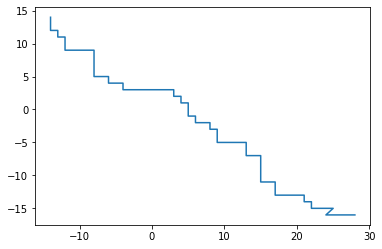

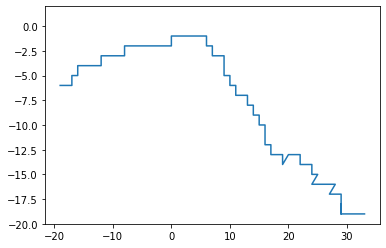

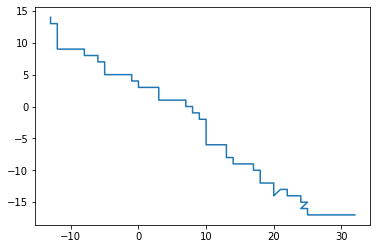

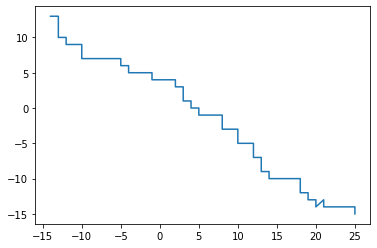

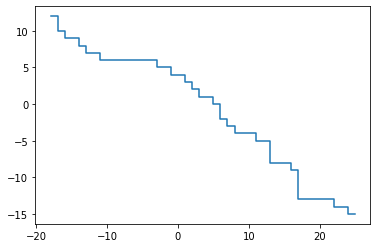

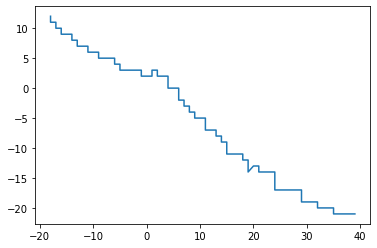

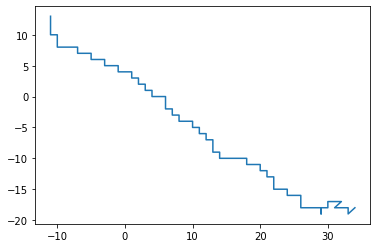

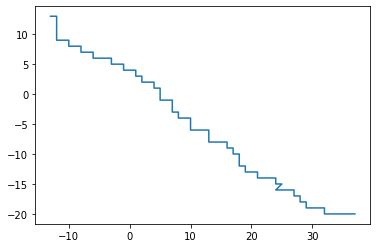

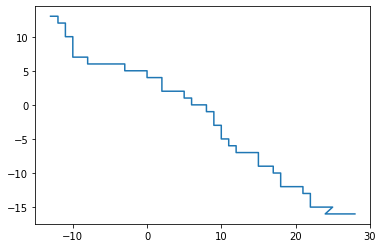

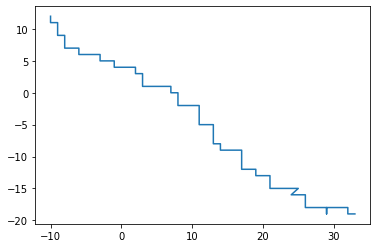

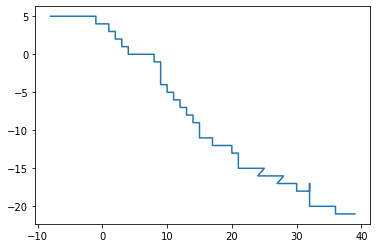

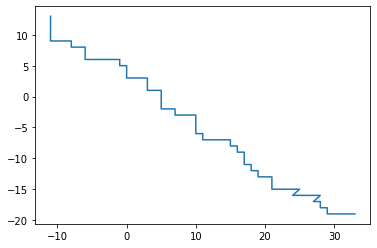

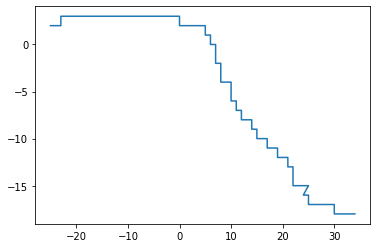

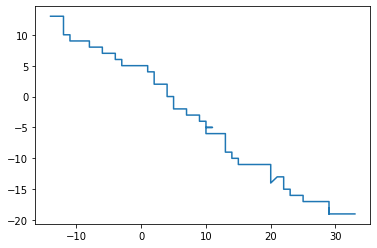

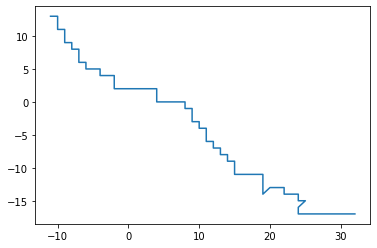

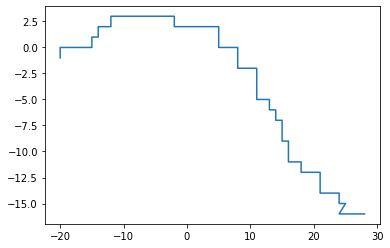

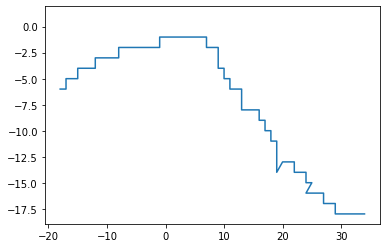

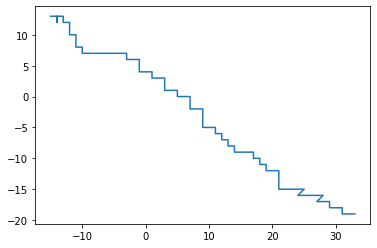

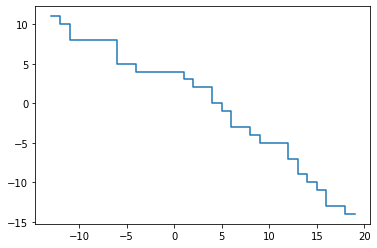

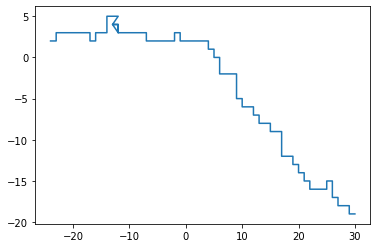

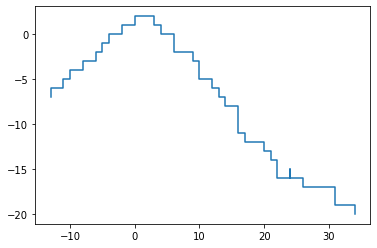

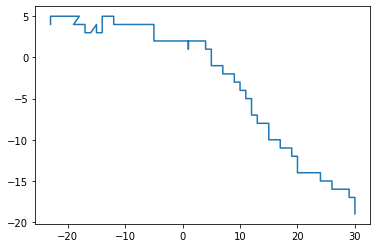

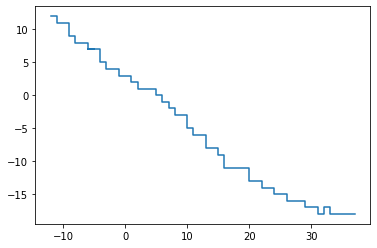

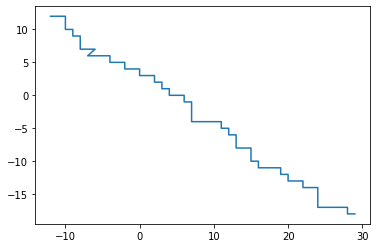

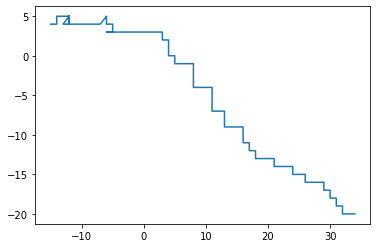

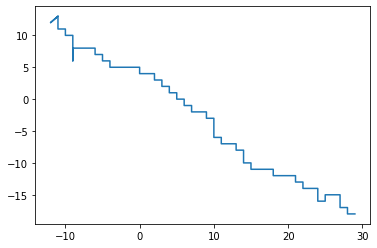

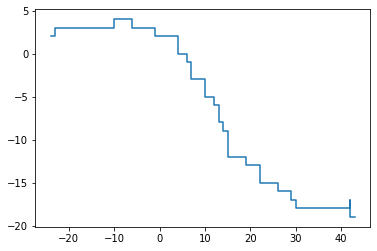

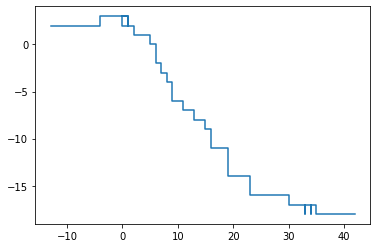

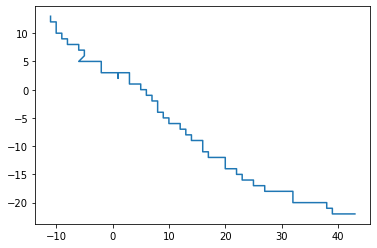

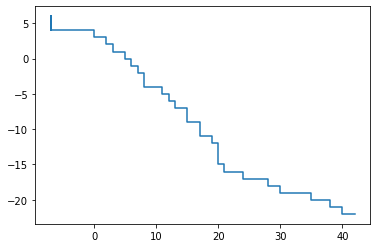

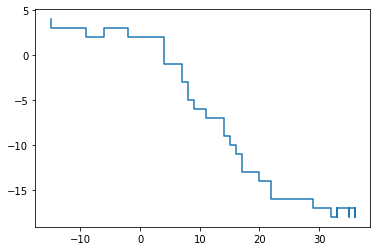

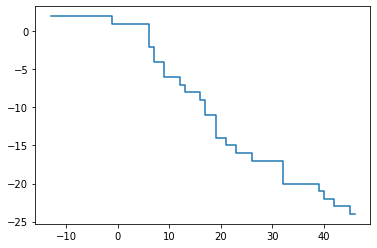

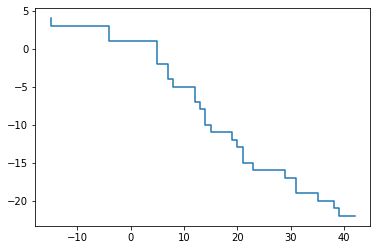

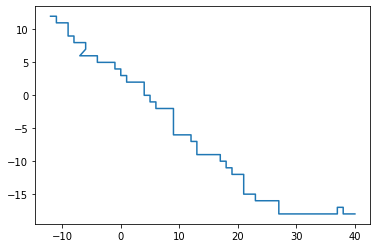

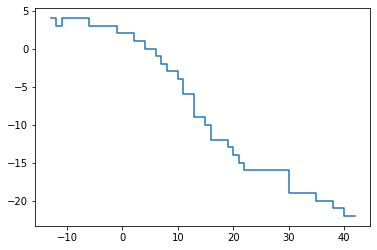

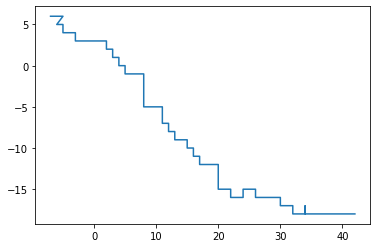

KeyboardInterrupt: 

In [28]:
for i in range(len(GEN_TR)):
    x = [p[0] for p in GEN_TR[i]]
    y = [p[1] for p in GEN_TR[i]]
    plt.plot(x,y,1)
    plt.show()

### 中心节点处理方式
- 依据初始点、转移矩阵、状态集合和最大生成长度生成网格化轨迹数据
- 生成的网格化数据进行聚类操作

#### 注意
对比试验的时候，将所有数据进行网格化后，在通过比对簇心来得到标签